In [2]:
from __future__ import division, print_function
import pandas as pd
import hashlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.special import binom

For size reasons, some of the csv used in this notebook are not disponible on github and need to be generated using IGoR (https://github.com/qmarcou/IGoR). The generation command of IGoR is:
```{bash}
igor -set_wd ./ -species human -chain beta -generate 100000
```

## Beta sequences

In [5]:
dfby_exp = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_beta_Y.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])
dfbx_exp = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_beta_X.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])

# need to be generated first
# need roughly 100 000 000 sequences, remove out-of-frame sequences for size (sequences without a CDR3) 
dfb_gen = pd.read_csv("../../published_code/Datas/sharing/gen_CDR3_beta_werr_inframe.tsv.gz", sep="\t",
                     header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])

In [6]:
# keep only productive sequences
for df in [dfby_exp, dfbx_exp, dfb_gen]:
    df["isinframe"] = df.sequence.apply(lambda x:len(str(x))%3 == 0)
    df["stopcodon"] = df.amino.apply(lambda x: ('*' in str(x)))

dfby_exp_prod = dfby_exp[dfby_exp.isinframe & ~dfby_exp.stopcodon].copy()
dfbx_exp_prod = dfbx_exp[dfbx_exp.isinframe & ~dfbx_exp.stopcodon].copy()
dfb_gen_prod = dfb_gen[dfb_gen.isinframe & ~dfb_gen.stopcodon].copy()

# hash function definition
dfb_gen_prod["hash"] = dfb_gen_prod.amino.apply(
    lambda x: 
    int(hashlib.md5(str(x).encode('utf-8')).hexdigest()[:12],16)/int("F"*12,16))

# remove sequences duplicates (no way of distinguishing those from identical reads)
dfb_gen_prod = dfb_gen_prod.drop_duplicates(subset=["sequence"])
dfbx_exp_prod = dfbx_exp_prod.drop_duplicates(subset=["sequence"])
dfby_exp_prod = dfby_exp_prod.drop_duplicates(subset=["sequence"])

MemoryError: 

In [ ]:
qb = 0.037
dfb_gen_selected = dfb_gen_prod[dfb_gen_prod.hash <= qb]

In [ ]:
nb_mean = 5
samples_b = range(1000, len(dfb_gen_selected), len(dfb_gen_selected)//50) 
res_gen_b = []
for n in samples_b:
    res_gen_b.append(np.mean([len(np.unique(dfb_gen_selected.sample(n).amino.values)) for _ in range(nb_mean)]))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4.,2.5))
sns.set_style("white")
ax.plot(samples_b, res_gen_b, color='blue', label="Generated, $q=0.037$")
#plt.title("Simulation of the number of unique amino-acid for a sample of size N")
ax.scatter([len(dfbx_exp_prod), len(dfby_exp_prod)],
         [len(np.unique(dfbx_exp_prod.amino)), len(np.unique(dfby_exp_prod.amino))],
         color='red',marker='X', label="Experiments")
ax.legend()
plt.xlabel("# nuc.")
plt.ylabel("# a.a.")
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.tight_layout()
plt.savefig("aa_vs_nuc_beta.pdf")
plt.show()

## Alpha sequences

In [ ]:
dfax_exp = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_alpha_X.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])
dfay_exp = pd.read_csv("../Datas/sharing/exp_gdna_CDR3_alpha_Y.tsv.gz", sep="\t"
                     ,header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])

# need to be generated first
# need roughly 100 000 000 sequences, remove out-of-frame sequences for size (sequences without a CDR3) 
dfa_gen = pd.read_csv("../Datas/sharing/gen_CDR3_alpha_werr_inframe.tsv.gz", sep="\t",
                     header=None, names=["CDR3", "sequence", "amino", "_", "__", "___"])


dfax_exp = dfax_exp.dropna(subset = ['amino']).copy()
dfay_exp = dfay_exp.dropna(subset = ['amino']).copy()
dfa_gen = dfa_gen.dropna(subset = ['amino']).copy()

In [ ]:
# keep only productive sequences
for df in [dfax_exp, dfay_exp, dfa_gen]:
    df["isinframe"] = df.sequence.apply(lambda x:len(str(x))%3 == 0)
    df["stopcodon"] = df.amino.apply(lambda x: ('*' in str(x)))
dfax_exp_prod = dfax_exp[dfax_exp.isinframe & ~dfax_exp.stopcodon].copy()
dfay_exp_prod = dfay_exp[dfay_exp.isinframe & ~dfay_exp.stopcodon].copy()
dfa_gen_prod = dfa_gen[dfa_gen.isinframe & ~dfa_gen.stopcodon].copy()

# hash function definition
dfa_gen_prod["hash"] = dfa_gen_prod.amino.apply(
    lambda x: 
    int(hashlib.md5(str(x).encode('utf-8')).hexdigest()[:12],16)/int("F"*12,16))

# remove sequences duplicates (no way of distinguishing those from identical reads)
dfa_gen_prod = dfa_gen_prod.drop_duplicates(subset=["sequence"])
dfax_exp_prod = dfax_exp_prod.drop_duplicates(subset=["sequence"])
dfay_exp_prod = dfay_exp_prod.drop_duplicates(subset=["sequence"])

In [4]:
qa = 0.16
dfa_gen_selected = dfa_gen_prod[dfa_gen_prod.hash <= qa]

In [5]:
nb_mean = 5
samples_a = range(1000, len(dfa_gen_selected), len(dfa_gen_selected)//10) 
res_gen_a = []
for n in samples_a:
    res_gen_a.append(np.mean([len(np.unique(dfa_gen_selected.sample(n).amino.values)) for _ in range(nb_mean)]))

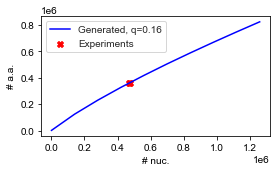

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,2.5))
ax.plot(samples_a, res_gen_a, color='blue', label="Generated, q=0.16")
sns.set_style("white")
#ax.set_title("Simulation of the number of unique amino-acid for a sample of size N")
ax.scatter([len(dfax_exp_prod),len(dfay_exp_prod)],
         [len(np.unique(dfax_exp_prod.amino)),len(np.unique(dfay_exp_prod.amino))],
          color='red',marker='X', label="Experiments")
ax.legend()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("# nuc.")
plt.ylabel("# a.a.")
plt.tight_layout()
plt.savefig("aa_vs_nuc_alpha.pdf")
plt.show()

## Nucleotide sharing estimation

We compute then interpolate over generated distributions of the generation's probabilities of $\alpha-\beta$ (with both chains supposed independant). 

This is based on the paper www.arxiv.org/pdf/1803.01056.pdf (see methods)

Then we can compute the number $M_k(\{N_i\}_{i \in 1 \cdots k})$ of shared nucleotide between $k$ individuals, with sample sizes $\{N_i\}_{i \in 1 .. k}$, the generating function of those numbers can be approximated by: 
$$
G(x, \{N_i\}) = \sum_{n=0}^k M_{n}(\{N_i\}) x^{n} \approx \int_{0}^{\infty} dE\  p(E)\  e^E  \prod_{i=1}^k \left[ e^{-N_i e^{-E}} + (1 - e^{-N_i e^{-E}})x\right]
$$

In [122]:
# extract generated nucleotides and associated pgen, for alpha and beta
df_pgen_beta = pd.read_csv("../Datas/sharing/Pgen_counts_beta.csv.gz", sep=";")
df_pgen_alpha = pd.read_csv("../Datas/sharing/Pgen_counts_alpha.csv.gz", sep=";")
pgen_b = df_pgen_beta.Pgen_estimate.values
pgen_b = pgen_b[~np.isnan(pgen_b)]
pgen_a = df_pgen_alpha.Pgen_estimate.values
pgen_a = pgen_a[~np.isnan(pgen_a)]
pgen_ab = np.multiply(df_pgen_beta.Pgen_estimate.values, df_pgen_alpha.Pgen_estimate.values)
pgen_ab = pgen_ab[~np.isnan(pgen_ab)]

In [268]:
def p_gen_distribution(pgen):
    sns.distplot(-np.log(pgen), label="Raw data")
    plt.title("Distribution of the Shannon surprise of the sequences")
    plt.xlabel("Shannon surprise")

    Es = -np.log(pgen)
    dE = 0.5
    bins=np.arange(dE/2, np.max(Es)+dE/2, dE) 
    hist, _ = np.histogram(Es, bins=np.arange(0, np.max(Es)+dE, dE), density=True)
    p = interp1d(bins, hist, fill_value=0., bounds_error=False)
    plt.plot(bins, p(bins),label="Interpolation")
    plt.legend()
    plt.show()
    return p

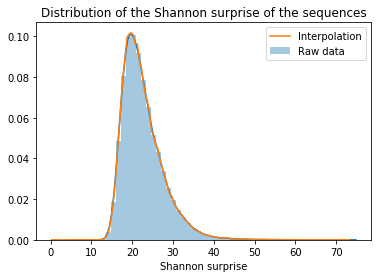

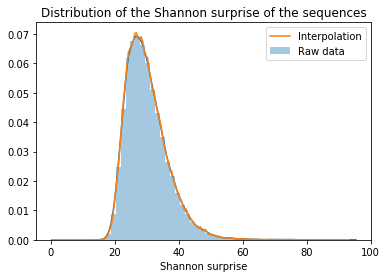

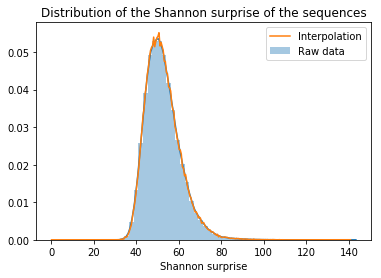

In [269]:
pa = p_gen_distribution(pgen_a)
pb = p_gen_distribution(pgen_b)
pab = p_gen_distribution(pgen_ab)

Compute  $M_0(N)$ and $M_m(\{N\}_{i \in 1 \cdots k})$ (beware : for nucleotides)

In [375]:
def M0(N, p, qfs):
    return integrate.quad(lambda E: (p(E-np.log(qfs))
                          *np.exp(E)*(1-np.exp(-N*np.exp(-E))) 
                                     if (E < (20 + np.log(N))) 
                                     else p(E-np.log(qfs))*N), 
                          0, 100, epsrel=1e-15, limit=100)[0]
def M(m, N, k, p, qfs):
    return integrate.quad(lambda E: integrandM(E, m, N, k, p, qfs), 
                          0, 100, epsrel=1e-15, limit=100)[0]

def integrandM(E, m, N, k, p, qfs):
    u = np.exp(np.log(N) - E)
    if E > (10 + np.log(N)): 
        return (p(E-np.log(qfs))*binom(m,k)
                *np.exp(-u*(m-k))*u**(k-1)*N)
    else:
        return (p(E-np.log(qfs))*binom(m,k)
                *np.exp(-u*(m-k))*((1 - np.exp(-u))**k)*N/u)

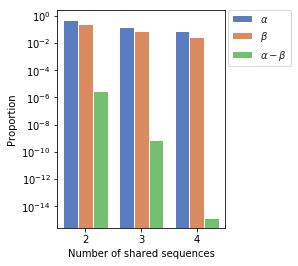

In [11]:
fig, ax = plt.subplots(1,1,figsize=(3,4))
N = 1e6
df = pd.DataFrame(columns=["nb_shared", "proportion","type"])
df["type"] = [r"$\alpha$"]*3+[r"$\beta$"]*3+[r"$\alpha-\beta$"]*3
df["nb_shared"] = list(range(2,5))*3
df["proportion"] = ([M(n, N, 10, pa, qfa)/N for n in range(2,5)] +
                    [M(n, N, 10, pb, qfb)/N for n in range(2,5)] +
                    [M(n, N, 10, pab, qfb * qfa)/N for n in range(2,5)])
sns.set_palette(sns.color_palette("muted"))
sns.set_style("white")
g = sns.barplot(x="nb_shared", y="proportion", hue="type", data=df)
g.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
g.set_ylabel('Proportion')
g.set_xlabel('Number of shared sequences')
g.set_yscale('log')
plt.savefig("number_shared_sequences.pdf")
plt.show()

In [390]:
# Comparaison with the paper of Grigaityte -- Jiang
N = 40000
print("Number of cells sharing a full TCR predicted", sum((M(5, N, k, pab, qfb*qfa) for k in range(2,6))))
print("Same, with a x10000 response", sum((M(5, N, k, pab, qfb*qfa/10000) for k in range(2,6))))

Number of cells sharing a full TCR predicted 0.0010054160376114462
Same, with a x10000 response 9.40810404309636


In [407]:
N=1e11
print("Proportion of sequences shared between two individuals: ",
      M(2,N,2,pab, qfa*qfb)/N*100, "%")

0.2048803147130515


## $\beta$-$\alpha$ sharing

Generate a *large* file.
```{bash}
igor -set_wd ../Datas/sharing/ -species human -chain beta -generate 150000000 --CDR3 --noerr
mv ../Datas/sharing/generated/generated_seqs_noerr_CDR3_info.csv ../Datas/sharing/generated_betas.csv
rm -r ../Datas/sharing/generated
```{bash}

In [16]:
table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
    } 

def to_amino(x):
    s = ""
    for i in range(0,len(x),3):
        s += table[x[i:i+3]]
    return s

qb = 0.037
filename = "/home/tautilde/Storage/tmp/generated/generated_seqs_noerr_CDR3_info.csv"#"../Datas/sharing/generated_betas.csv"

with open(filename, "r") as f:
    with open("../Datas/sharing/generated_betas_kept.csv", "w") as fw:
        fw.write(f.readline().strip() + ",amino,hash\n")
        for l in f:
            # remove non inframe sequences or sequence with a stop codon
            if l.strip().split(",")[3] != "0":
                seq = l.strip().split(",")[1]
                aa = to_amino(seq)
                hsh = int(hashlib.md5(str(aa).encode('utf-8')).hexdigest()[:12],16)/int("F"*12,16)
                if ("_" not in aa):
                    fw.write(l.strip() + "," + aa + "," + str(hsh) + "\n")

In [99]:
dfb_gen = pd.read_csv("../Datas/sharing/generated_betas_kept.csv",
                      sep=",", usecols=["nt_CDR3", "amino", "hash"], nrows=1000000)

table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
    } 


dfb_gen["amino"] = dfb_gen.nt_CDR3.apply(to_amino)

In [100]:
dfb_gen_left = dfb_gen[dfb_gen.hash < 0.037/10.].copy()
print(len(dfb_gen_left[dfb_gen_left.nt_CDR3.duplicated()])/len(dfb_gen_left))
print(len(dfb_gen_left))

0.0019171779141104294
36512


In [399]:
N = 50000000
print(1. - M0(N, pab, 0.037*0.26)/N)

8.043623660858312e-05


In [102]:
print(len(np.unique(dfb_gen.nt_CDR3))/len(dfb_gen))

0.997853
